In [ ]:
# !pip install tensorflow[and-cuda]
# !pip install pandas
# !pip install yfinance
# !pip install scikit-learn  
# !pip install plotly
# !pip install imblearn
# !pip install seaborn
# !pip install keras-tuner
# !pip install --upgrade nbformat
# !pip install scikit-learn tensorflow
# !pip install keras
# !pip install scikeras
# !pip install scikeras[tensorflow]
# !pip install scikeras tensorflow

In [4]:
import warnings

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinancetool as yft
import techinal_indicato as ti
import model_helper as ml
import plots
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2,f_classif
import importlib
import tensorflow
import os
import random

#https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
# Set random seeds for reproducibility
# This ensures that the results are consistent across runs
random.seed(42)
np.random.seed(42)
tensorflow.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Reload custom modules to reflect any changes made to them
importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)

<module 'plots' from 'd:\\UH\\DataScienceProject\\DataScienceProject\\code\\plots.py'>

##Pre-preocessing

In [5]:

importlib.reload(ti)
importlib.reload(yft)
importlib.reload(ml)
importlib.reload(plots)

# Set the download path for CSV files
basepath = "../data/"

# Initialize a helper class for downloading stock data
yfh = yft.YFinanceHelper(basepath)
# Initialize a helper class for calculating technical indicators
tih = ti.TechinalIndicatoHelper()

# Stock data download start date
sd = '2000-01-01'
# Stock data download end date
ed = '2023-12-31'

# Training data ends on this date, remaining data will be used for testing
training_end_date_Str = '2021-12-31'

# Download dataset for microsoft and apply technical indicators
stock_df_with_indecators_MSFT = tih.get_dataset(yfh,"MSFT",sd,ed,28)  # .apply_techinal_indicators(stock_df, 28)

# Split data for training and testing
training_stock_df_with_indecators_MSFT = stock_df_with_indecators_MSFT[(stock_df_with_indecators_MSFT['Date'] < pd.to_datetime(training_end_date_Str))]
testing_stock_df_with_indecators_MSFT = stock_df_with_indecators_MSFT[(stock_df_with_indecators_MSFT['Date'] >= pd.to_datetime(training_end_date_Str))]


## Class distribution

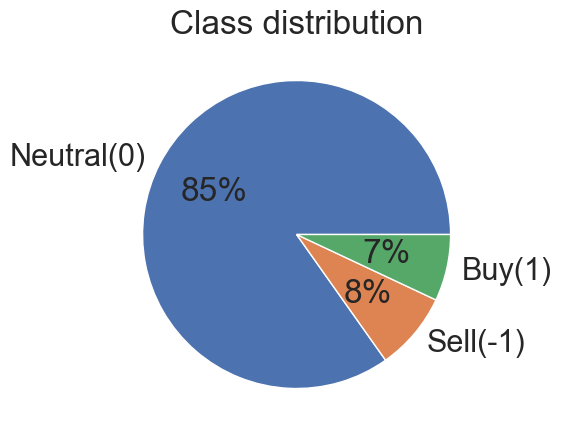

In [6]:
# Reload the 'plots' module to ensure the latest version is used
importlib.reload(plots)

# Initialize the PlotHelper class from the 'plots' module
plt_helper = plots.PlotHelper()

# Plot the class distributio buy sell or neutral signals for the microsoft data with technical indicators
plt_helper.plot_class_distribution(stock_df_with_indecators_MSFT)

## Feature selection

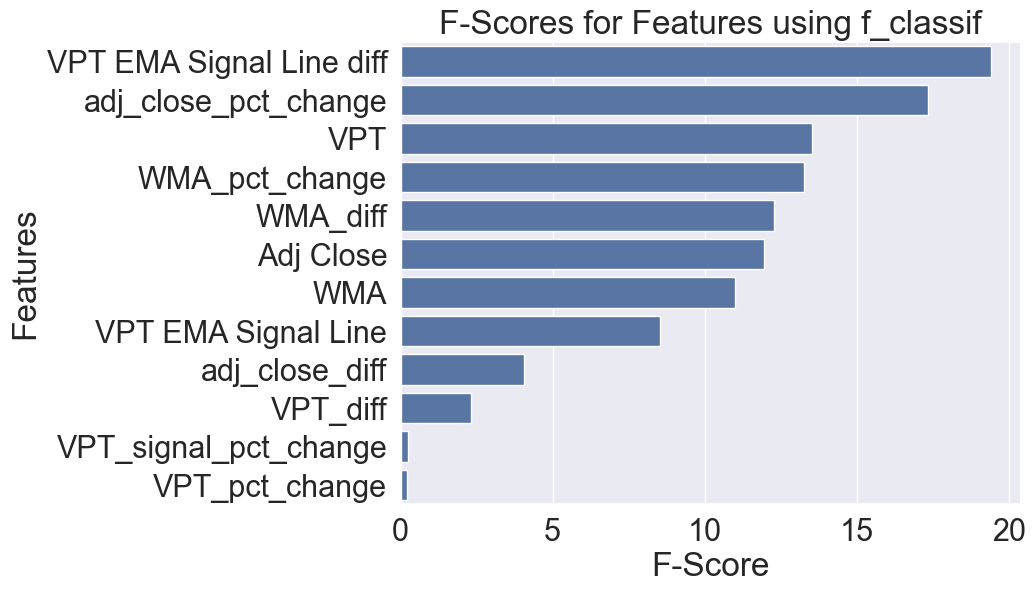

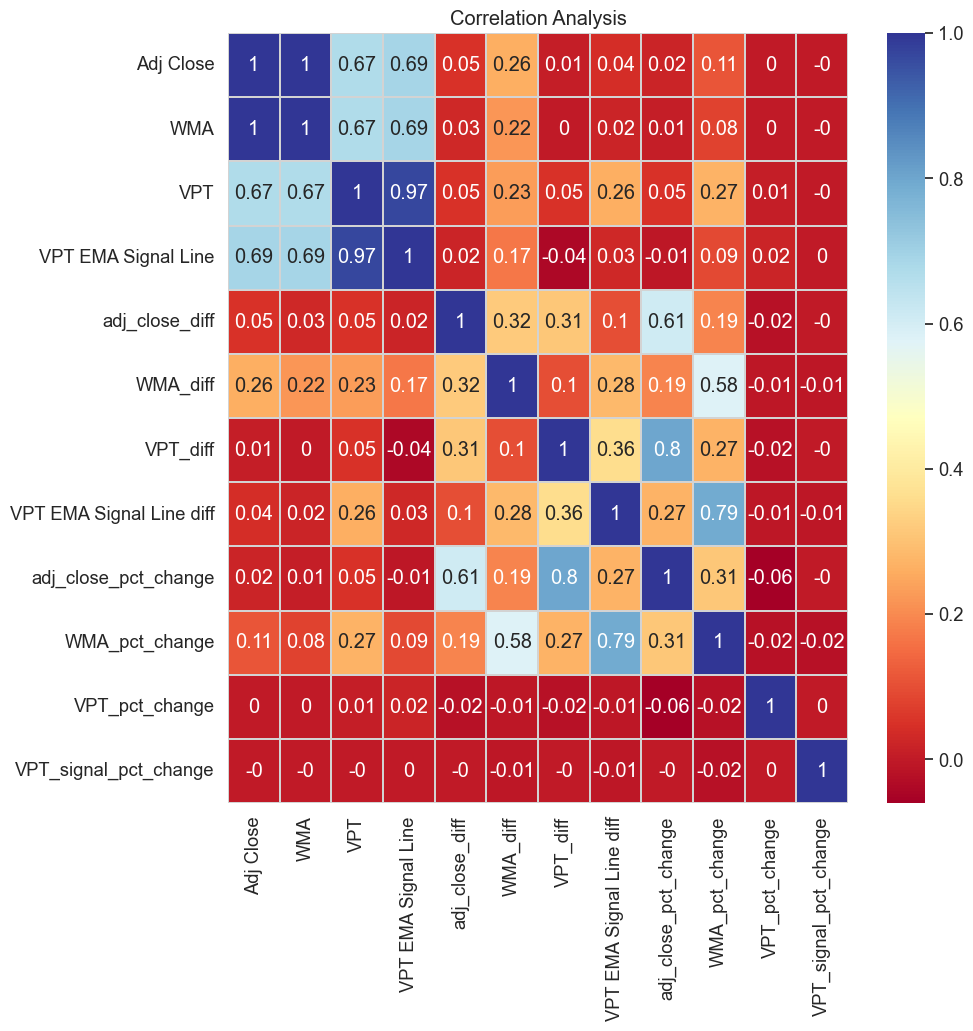

In [7]:
# Extracting the features (independent variables) from the DataFrame
X = stock_df_with_indecators_MSFT[['Adj Close','WMA','VPT','VPT EMA Signal Line','adj_close_diff','WMA_diff',"VPT_diff","VPT EMA Signal Line diff",'adj_close_pct_change', 'WMA_pct_change',"VPT_pct_change","VPT_signal_pct_change"]]
# Setting the target variable
y = stock_df_with_indecators_MSFT['WMA VPT Signal']  # Target column

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
# Feature selection using SelectKBest with the f_classif statistical test
# This method selects the best features based on their ANOVA F-value
# 'k' can be adjusted to select a specific number of features
selector = SelectKBest(score_func=f_classif,k='all')
# Fit the selector to the features and target
X_selected = selector.fit(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features using their indices
selected_feature_names = X.columns[selected_feature_indices]

# Create a DataFrame to hold feature names and their corresponding scores
df_feature = pd.DataFrame()
df_feature["columns"]=X.columns
df_feature["scores"]=X_selected.scores_
# Sort the DataFrame by scores in descending order
df_feature= df_feature.sort_values(by=['scores'],ascending=False)

# Plot the feature selection scores using the PlotHelper class
plt_helper.plot_feature_selection_score(X.columns,X_selected.scores_)
# Plot the correlation matrix for the features
plt_helper.plot_correlation_matrix(X)

## Visualize technical indicator

MSFT WMA Signal : Final Profit: $1673.55, 16.74%
MSFT VPT Signal : Final Profit: $299.49, 2.99%
MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%


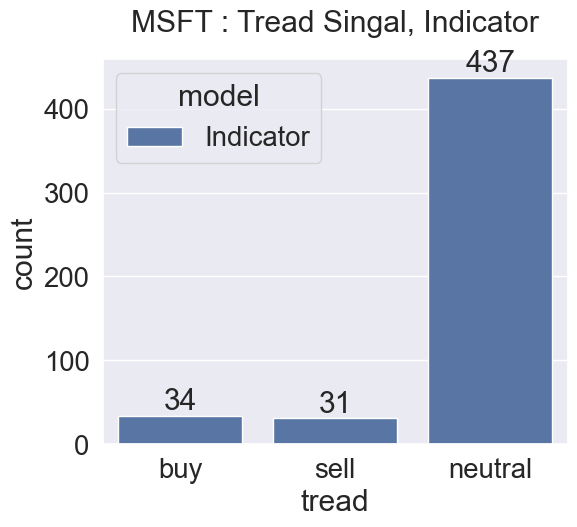

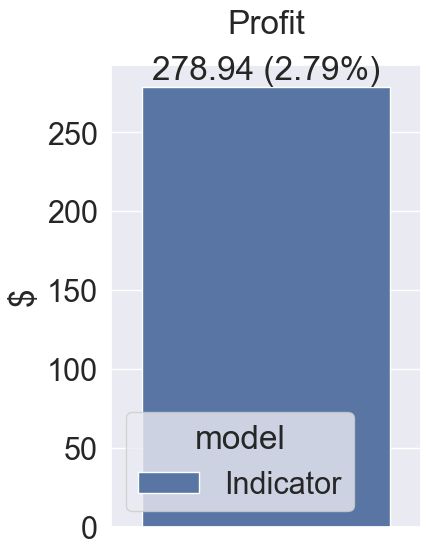

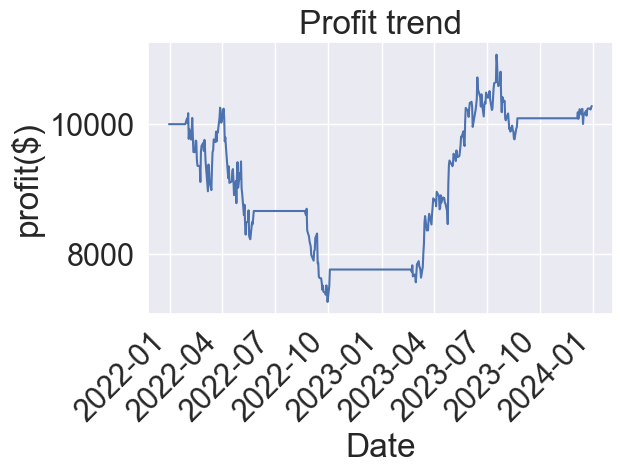

In [8]:
# Reload the 'plots' module to ensure the latest version is used
importlib.reload(plots)
# Initialize the PlotHelper class from the 'plots' module
plt_helper = plots.PlotHelper()

# Plot the WMA Signal for MSFT using the testing dataset
plt_helper.plot('MSFT','WMA Signal',testing_stock_df_with_indecators_MSFT)
# Plot the VPT Signal for MSFT using the testing dataset
plt_helper.plot_vpt('MSFT',testing_stock_df_with_indecators_MSFT)
# Plot the combined WMA and VPT Signal for MSFT using the testing dataset
plt_helper.plot('MSFT','WMA VPT Signal',testing_stock_df_with_indecators_MSFT)

# Calculate and print profit using WMA Signal
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["WMA Signal"])
print("MSFT"+f" WMA Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

# Calculate and print profit using VPT Signal
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["VPT Signal"])
print("MSFT"+f" VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

# Calculate and print profit using combined WMA VPT Signal
vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock_df_with_indecators_MSFT["Adj Close"],testing_stock_df_with_indecators_MSFT["WMA VPT Signal"])
print("MSFT"+f" WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")

# Count the occurrences of each signal (buy, sell, neutral) in the testing dataset
vpt_signal_counts = testing_stock_df_with_indecators_MSFT["WMA VPT Signal"].value_counts()

# Create a DataFrame to visualize the signal counts
df = pd.DataFrame({
'model': ["Indicator","Indicator","Indicator"],
'tread': ["buy","sell","neutral"],
'count' : [vpt_signal_counts[1],vpt_signal_counts[-1],vpt_signal_counts[0]]
})

# Plot the signal counts using the PlotHelper class
plt_helper.plot_signals("MSFT" + " : Tread Singal, Indicator",df)

# Create a DataFrame to visualize the profit
df_profit_price = pd.DataFrame({
'model': ["Indicator"],
'type': ["Profit"],
'count' : [vpt_profit.round(2)],
'pct' : [vpt_profit_percentage.round(2)]
})

# Plot the profit comparison using the PlotHelper class
plt_helper.plot_profit_compare("Profit",df_profit_price['count'],df_profit_price['pct'],df_profit_price["model"])    
# Plot the profit trend over time using the PlotHelper class
plt_helper.plot_profit_trend("Profit trend",testing_stock_df_with_indecators_MSFT['Date'], vpt_portfolio_value)


# Model Treaning

In [10]:
# Reload the 'plots' module to ensure the latest version is used
importlib.reload(plots)

def print_profit(ticker_symbol,model_name, ml_obj ,model ,scaler,testing_stock,features):
# Function to compare the profit between a machine learning model and an indicator

    # Check if the model is provided; if not, use the saved model for predictions
    if model is not None:
        print("Not none")
        mode_signal = ml_obj.predict_signals(model,scaler,testing_stock,features)
    else:
        print("Not none")
        mode_signal = ml_obj.predict_signals_from_saved_model(testing_stock,features)
    
    # Count the occurrences of each signal (buy, sell, neutral) in the model's predictions
    model_signal_counts = mode_signal.value_counts()
    # Ensure all signals are accounted for, even if not present in the predictions
    if not -1 in model_signal_counts.index:
        model_signal_counts[-1]=0
    if not 1 in model_signal_counts.index:
        model_signal_counts[1]=0
    if not 0 in model_signal_counts.index:
        model_signal_counts[0]=0
    
    # Count the occurrences of each signal (buy, sell, neutral) in the indicator's signals
    vpt_signal_counts = testing_stock["WMA VPT Signal"].value_counts()
    print(model_signal_counts)

    # Create a DataFrame to compare the signal counts between the model and the indicator
    df = pd.DataFrame({
    'model': ["ML Model","ML Model","ML Model","Indicator","Indicator","Indicator"],
    'tread': ["buy","sell","neutral","buy","sell","neutral"],
    'count' : [model_signal_counts[1],model_signal_counts[-1],model_signal_counts[0],
             vpt_signal_counts[1],vpt_signal_counts[-1],vpt_signal_counts[0]]

    })

    # Plot the signal comparison using the PlotHelper class
    plt_helper.plot_signals(ticker_symbol + " : Tread Singal, Indicator vs "+model_name, df)

   
    # Calculate and print profit using the indicator's signals
    vpt_profit, vpt_portfolio_value, vpt_profit_percentage = tih.calculate_profit(testing_stock["Adj Close"],testing_stock["WMA VPT Signal"])
    print(ticker_symbol+f" WMA VPT Signal : Final Profit: ${vpt_profit:.2f}, {vpt_profit_percentage.round(2)}%")
    
    print()
    # Calculate and print profit using the model's predictions
    skip = len(testing_stock["Adj Close"]) - len(mode_signal)
    profit, portfolio_value, profit_percentage = tih.calculate_profit(testing_stock["Adj Close"][skip:],mode_signal)
    print(ticker_symbol+ " "+ model_name+ f" Signal : Final Profit: ${profit:.2f}, {profit_percentage.round(2)}%")
    
    # Create a DataFrame to compare profits between the model and the indicator
    df_profit_price = pd.DataFrame({
    'model': [model_name,"Indicator"],
    'type': ["Profit($)","Profit($)"],
    'count' : [profit.round(2),vpt_profit.round(2)],
    'pct' : [profit_percentage.round(2),vpt_profit_percentage.round(2)]
    })
    df_profit_price["str_val"] = (df_profit_price['count'].apply(str) + " (" + df_profit_price['pct'].apply(str)+"%)")
   
    print(df_profit_price)
    # Plot the profit comparison using the PlotHelper class
    plt_helper.plot_profit_compare3("Comparison of Profit",df_profit_price)
   
    # If the model's predictions are shorter than the testing dataset, pad the series with zeros
    if(len(mode_signal.values)<len(testing_stock)) :
        mode_signal = pd.concat([pd.Series(np.zeros(len(testing_stock)-len(mode_signal.values))), mode_signal])

    # Add the model's predictions to the testing DataFrame
    testing_stock[ticker_symbol + " "+ model_name] = mode_signal.values

    # Plot the signals using the PlotHelper class
    plt_helper.plot(ticker_symbol,ticker_symbol + " "+model_name,testing_stock)

    start  = len(testing_stock['Date'])- len(portfolio_value)
    # Plot the profit trend over time
    plt_helper.plot_profit_trend(ticker_symbol+ " " +"Profit trend ("+model_name+")",testing_stock['Date'][start:], portfolio_value)

    

## LogisticRegression

2192
Best parameters: {'C': 0.001, 'solver': 'newton-cg'}
Train Accuracy: 0.14811
Test Accuracy: 0.16286
Precission: 0.83415
Recall: 0.42883
f1: 0.49017
[[118   8  37]
 [534 669 632]
 [ 22  19 153]]


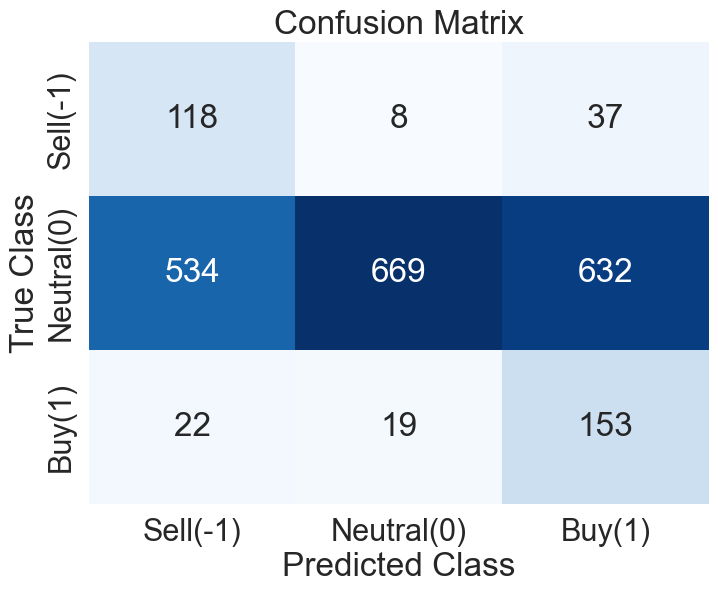

Not none
 1    216
-1    153
 0    133
Name: count, dtype: int64


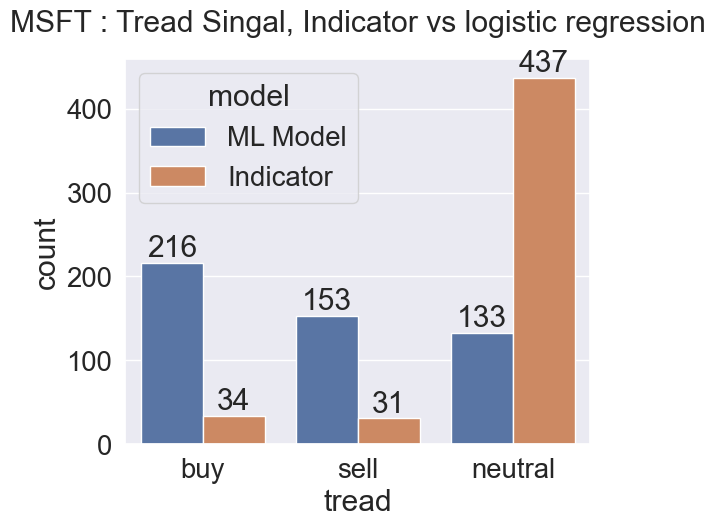

MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%

MSFT logistic regression Signal : Final Profit: $7214.21, 72.14%
                 model       type    count    pct           str_val
0  logistic regression  Profit($)  7214.21  72.14  7214.21 (72.14%)
1            Indicator  Profit($)   278.94   2.79    278.94 (2.79%)


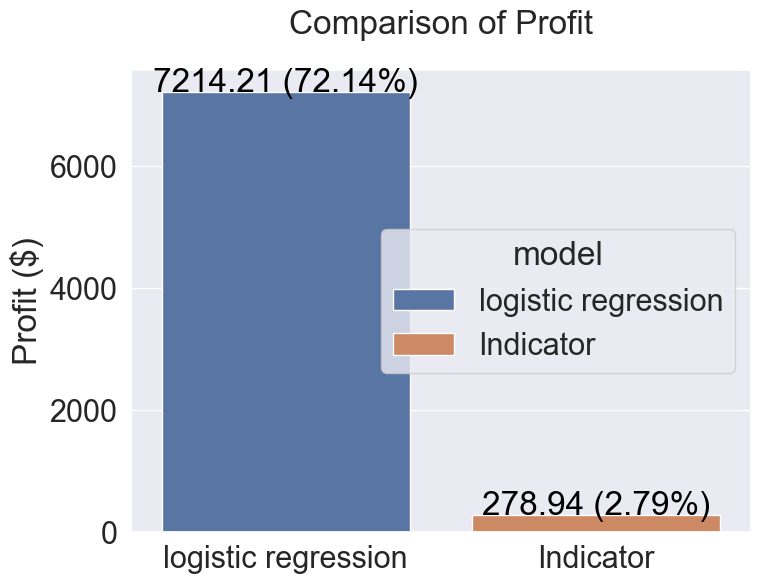

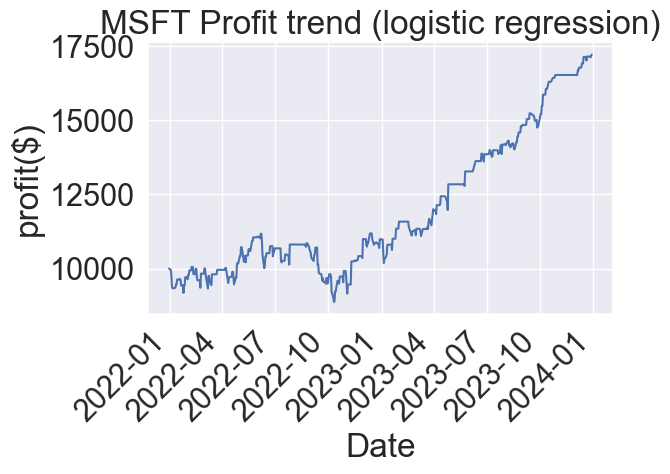

In [11]:
# Reload the 'ml' module to ensure the latest version is used
importlib.reload(ml)

# Define the feature columns to be used in the model
features = ["WMA_pct_change","VPT EMA Signal Line diff",'adj_close_pct_change']
# Define the target column
target = "WMA VPT Signal"

# Create an instance of the LogisticRegressionHelper class from the 'ml' module
ml_lr =  ml.LogisticRegressionHelper()

# Train the Logistic Regression model using the specified features and target
lr_models, scaler = ml_lr.train_logistic_regression_model(training_stock_df_with_indecators_MSFT,features,target)

# Print the profit and compare the model's performance against the indicator
print_profit("MSFT","logistic regression",ml_lr,lr_models,scaler,testing_stock_df_with_indecators_MSFT,features)

# Uncomment the following line to use a saved model for predictions and profit comparison
# print_profit("MSFT", "logistic regression", ml_lr, None, None, testing_stock_df_with_indecators_MSFT, features)

## GradientBoostClassifier

In [242]:
# Reload the 'ml' module to ensure the latest version is used
importlib.reload(ml)
# Define the feature columns to be used in the model
features = ["WMA_pct_change","VPT EMA Signal Line diff",'adj_close_pct_change']
# Define the target column
target = "WMA VPT Signal"

# Create an instance of the GradientBoostClassifierHelper class from the 'ml' module
ml_gb =  ml.GradientBoostClassifierHelper()

# Train the Gradient Boosting Classifier using the specified features and target
gb_models, scaler = ml_gb.train_gradient_classifier_model(training_stock_df_with_indecators_MSFT,features,target)
# Print the profit and compare the model's performance against the indicator
print_profit("MSFT","Gradient Boost",ml_gb,gb_models,scaler,testing_stock_df_with_indecators_MSFT,features)

# Uncomment the following line to use a saved model for predictions and profit comparison
# print_profit("MSFT", "Gradient Boost", ml_gb, None, None, testing_stock_df_with_indecators_MSFT, features)

## LSTM

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 28, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 150)            │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,103 (543.37 KB)

 Trainable params: 139,103 (543.37 KB)

 Non-trainable params: 0 (0.00 B)

class_weights_dict {0: 0.518053042771704, 1: 0.043245584027750104, 2: 0.4387013732005459}
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - loss: 0.2739 - precision: 0.2335 - recall: 0.0239 - val_loss: 1.2095 - val_precision: 0.2010 - val_recall: 0.0857 - learning_rate: 0.0010
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.2170 - precision: 0.2172 - recall: 0.1180 - val_loss: 1.1465 - val_precision: 0.1824 - val_recall: 0.1203 - learning_rate: 0.0010
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.1903 - precision: 0.2533 - recall: 0.1562 - val_loss: 1.0835 - val_precision: 0.1832 - val_recall: 0.1091 - learning_rate: 0.0010
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.1767 - precision: 0.2466 - recall: 0.1490 - val_loss: 1.0696 - val_precision: 0.1821 - val_recall: 0.1114 - learning_rate: 5.0000e-04
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.1596 - precision: 0.3185 - recall: 0.2222 - val_loss: 1.1186 - val_prec

[1.2431808710098267, 0.04948453605175018, 0.02672605775296688]
Validation Accuracy: 0.04948453605175018
Precission: 0.71545
Recall: 0.09465
f1: 0.1214
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
[[  68   22   80]
 [ 123  123 1616]
 [   2    1  146]]


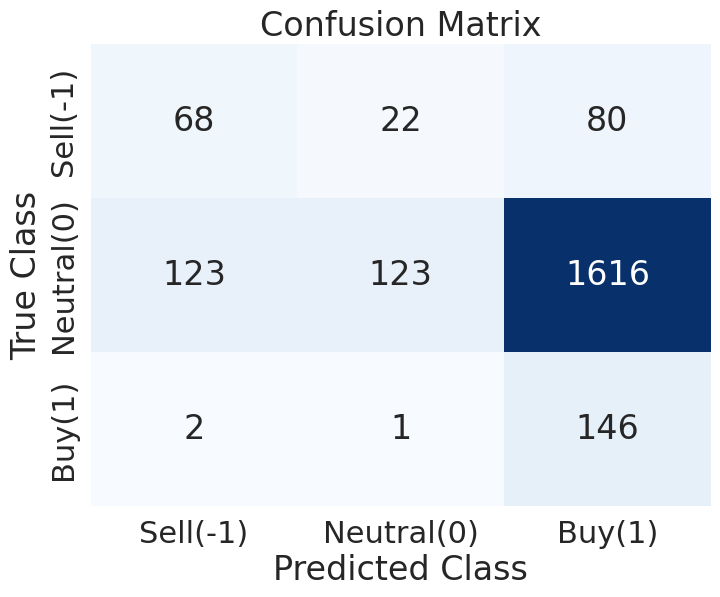

Final Test Precission: 0.75212
Final Test Recall: 0.15452
Final Test f1: 0.14381
Not none
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
 1    301
 0     94
-1     79
Name: count, dtype: int64


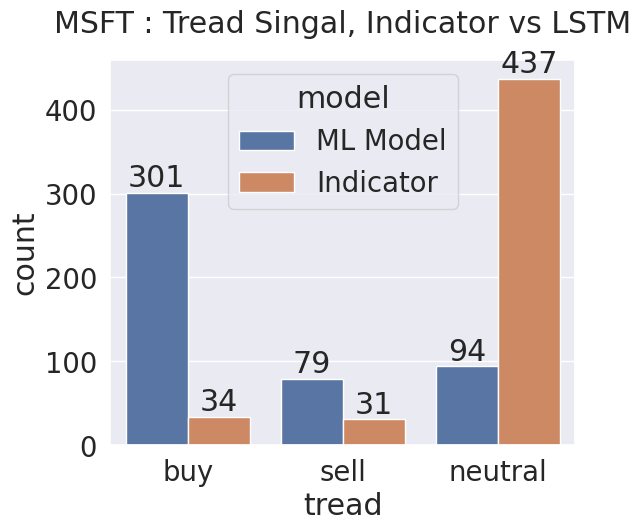

MSFT WMA VPT Signal : Final Profit: $278.94, 2.79%

MSFT LSTM Signal : Final Profit: $2394.84, 23.95%
       model       type    count    pct           str_val
0       LSTM  Profit($)  2394.84  23.95  2394.84 (23.95%)
1  Indicator  Profit($)   278.94   2.79    278.94 (2.79%)


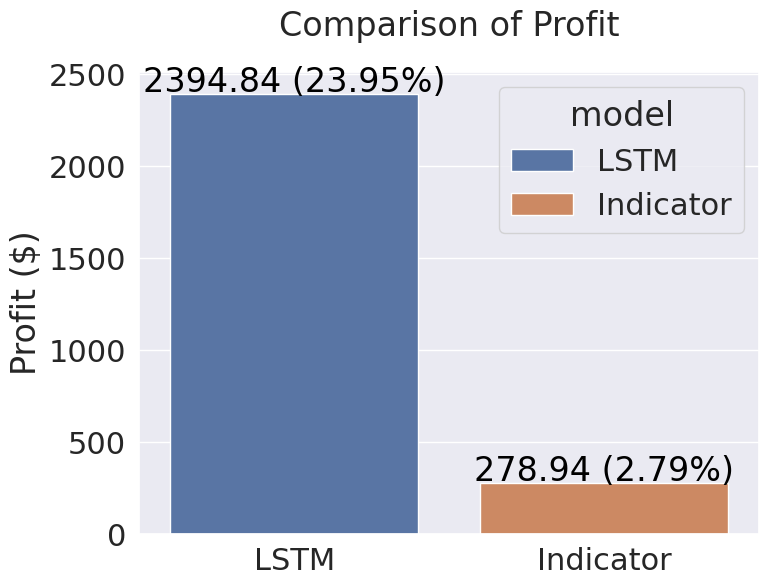

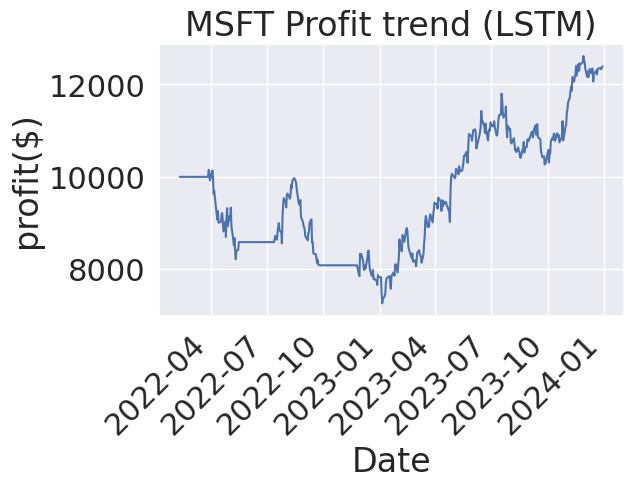

In [222]:
# Reload the 'ml' module to ensure the latest version is used
importlib.reload(ml)

# Create an instance of the LongShortTermMemoryMLHelper class from the 'ml' module
ml_lstm = ml.LongShortTermMemoryMLHelper()
# Set the time step for the LSTM model (this determines the number of previous time steps the model will consider)
ml_lstm.time_step = 28
# Define the feature columns to be used in the model
features = ["WMA_pct_change","VPT EMA Signal Line diff",'adj_close_pct_change']
# Define the target column
target = "WMA VPT Signal"
# Train the LSTM model using the specified features and target
lstm_models, scaler = ml_lstm.train_lstm_model(training_stock_df_with_indecators_MSFT,features,target)
# Print the profit and compare the model's performance against the indicator
print_profit("MSFT","LSTM",ml_lstm,lstm_models,scaler,testing_stock_df_with_indecators_MSFT,features)